In [34]:
%matplotlib inline


import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix

matplotlib.rcParams['figure.figsize'] = (10,10)

In [3]:
def corrolation_heatmap(data):
    ''' plot corrolation between numerical data in a heatmap style'''
    corr_matrix = data.corr()
    fig, ax = plt.subplots()
    cax = ax.imshow(corr_matrix.values, interpolation= 'nearest', cmap = 'bwr')
    ax.set_yticks(np.arange(len(list(corr_matrix)))+.5)
    ax.set_xticks(np.arange(len(list(corr_matrix)))+.5)
    ax.set_yticklabels(list(corr_matrix), rotation=0,fontsize=8,
    verticalalignment = 'bottom')
    ax.set_xticklabels(list(corr_matrix), rotation=90,fontsize=8,
    horizontalalignment= 'right')
    fig.colorbar(cax)

def partial_corrolation_plot(data, target = 'SalePrice', k = 10):
    ''' plot corrolation between most corrolated numerical attributes'''
    corr_matrix = data.corr()
    # get the most linear corrolated attributes
    important_features = \
    corr_matrix[target].abs().sort_values(ascending = False).index.values[:(k +1)]
    # calculate the corrolation for this subset
    corr_matrix = data[important_features].corr()
    fig, ax = plt.subplots()
    cax = ax.imshow(corr_matrix.values, interpolation= 'nearest', cmap = 'RdPu')
    ax.set_yticks(np.arange(len(list(corr_matrix)))+.5)
    ax.set_xticks(np.arange(len(list(corr_matrix)))+.5)
    ax.set_yticklabels(list(corr_matrix), rotation=0,fontsize=8,
    verticalalignment = 'bottom' )
    ax.set_xticklabels(list(corr_matrix), rotation=90,fontsize=8)
    fig.colorbar(cax)
    # write the value of corrolation on the plot
    for (j,i),label in np.ndenumerate(corr_matrix):
        ax.text(i,j,round(label,3),ha='center',va='center', fontsize =8)

### load data

In [4]:
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f218390>]], dtype=object)

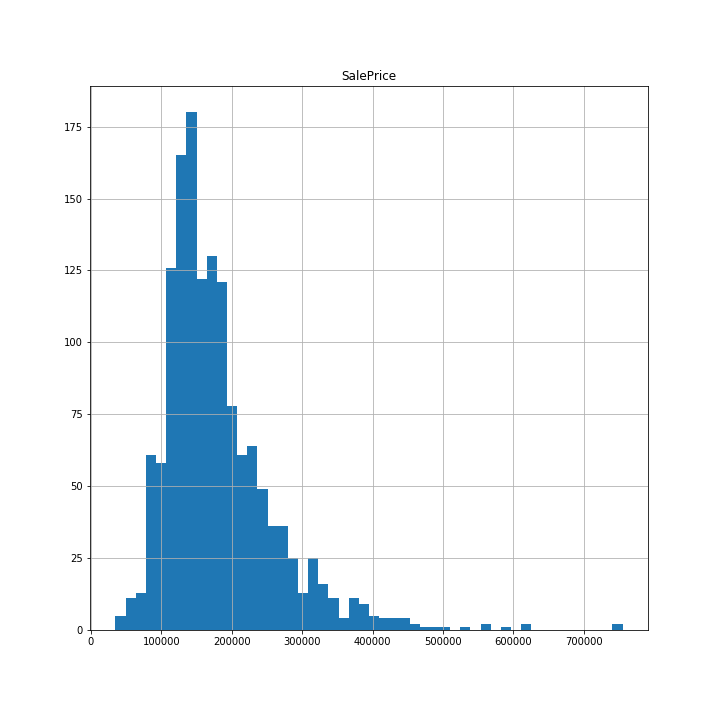

In [35]:
explore = data.copy()
# target value
explore.hist(column = 'SalePrice',bins = 50)

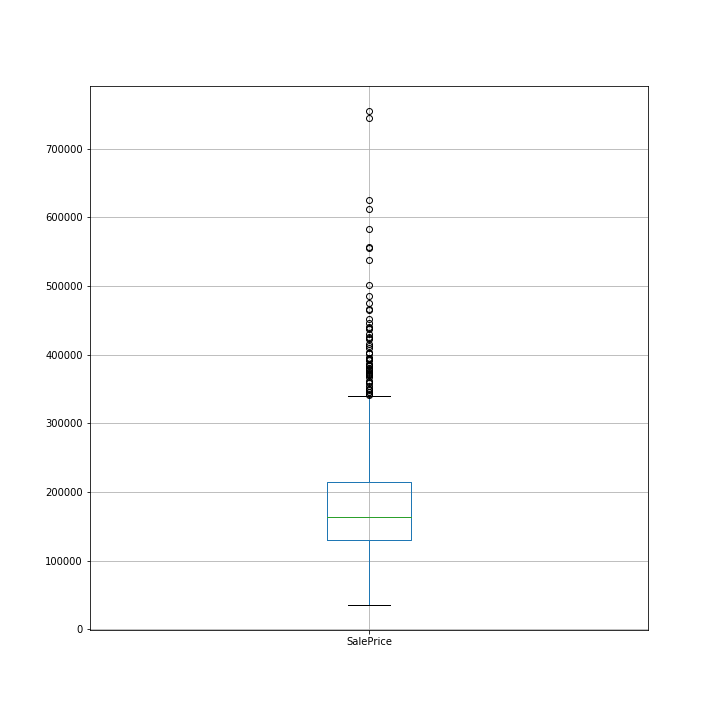

In [36]:
explore.boxplot(column = 'SalePrice')

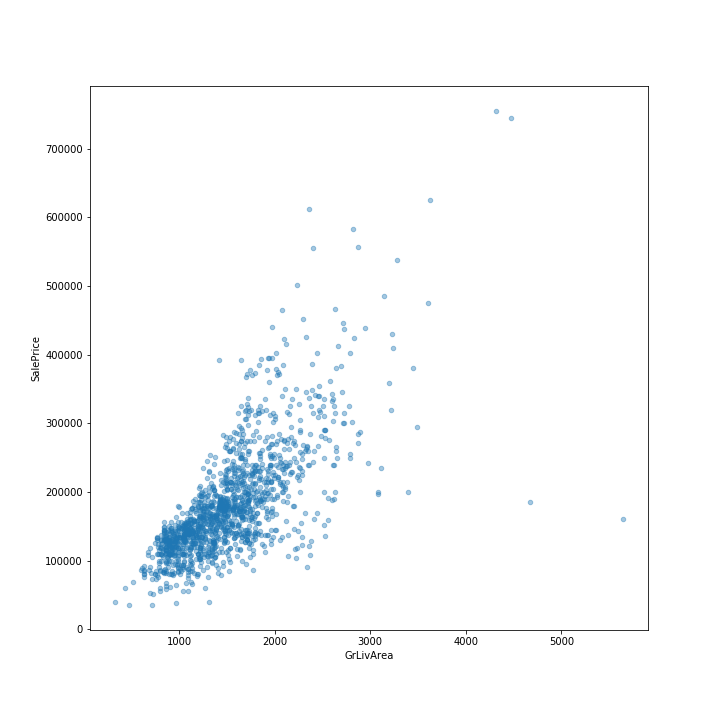

In [37]:
explore.plot.scatter(x = 'GrLivArea', y = 'SalePrice', alpha = .4)


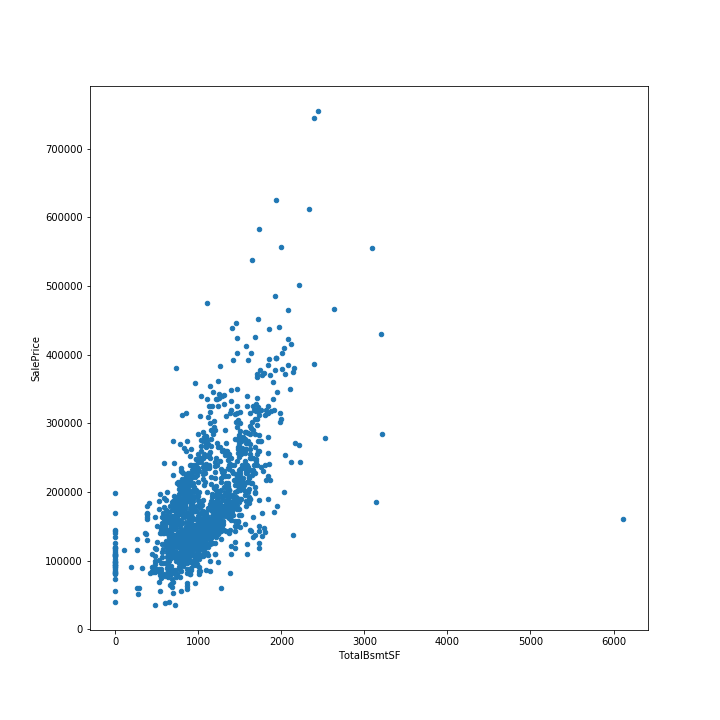

In [38]:
explore.plot.scatter(x = 'TotalBsmtSF', y = 'SalePrice')


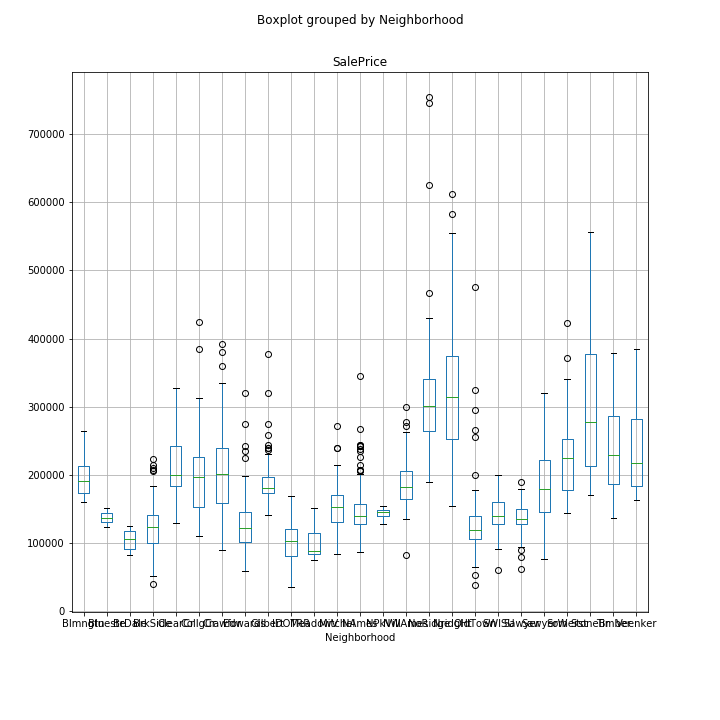

In [39]:
explore.boxplot(column = 'SalePrice', by = 'Neighborhood')

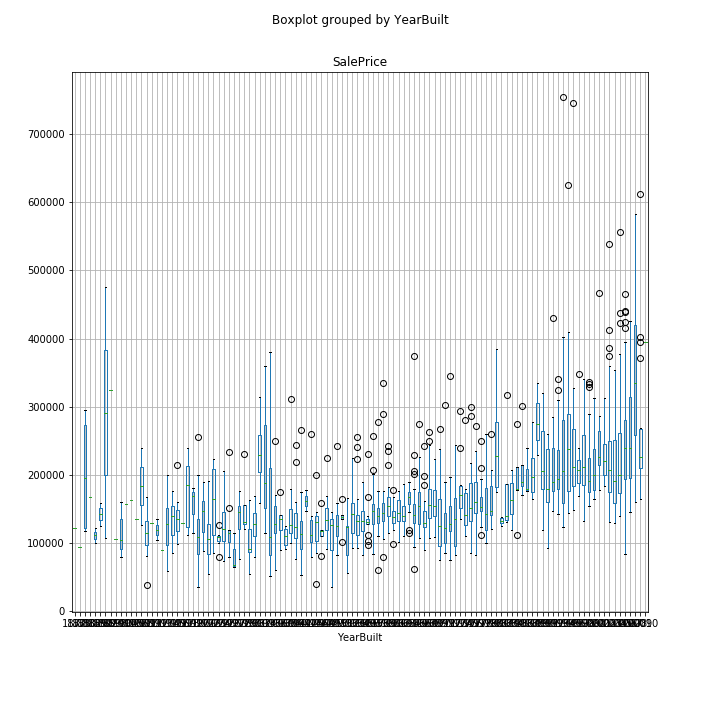

In [40]:
explore.boxplot(column = 'SalePrice', by = 'YearBuilt')


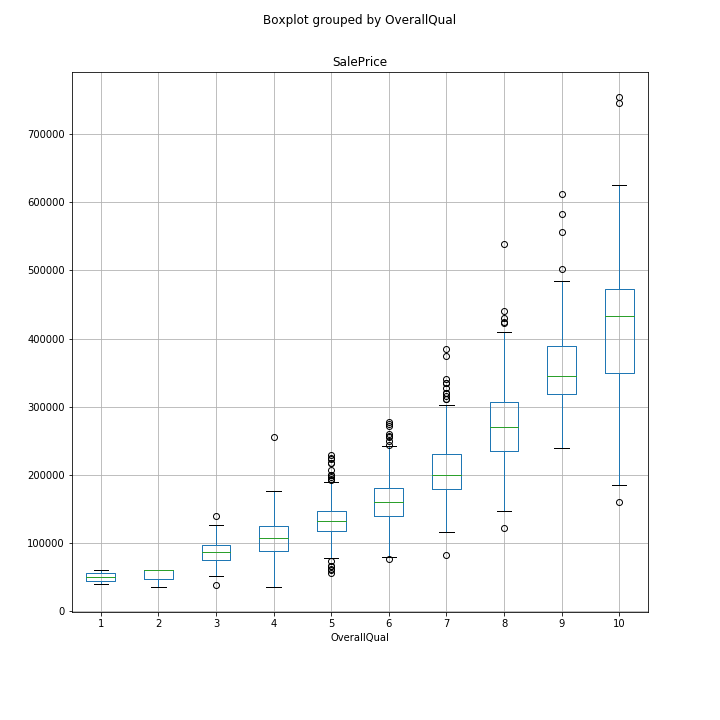

In [41]:
explore.boxplot(column = 'SalePrice', by = 'OverallQual')

<class 'pandas.core.frame.DataFrame'>


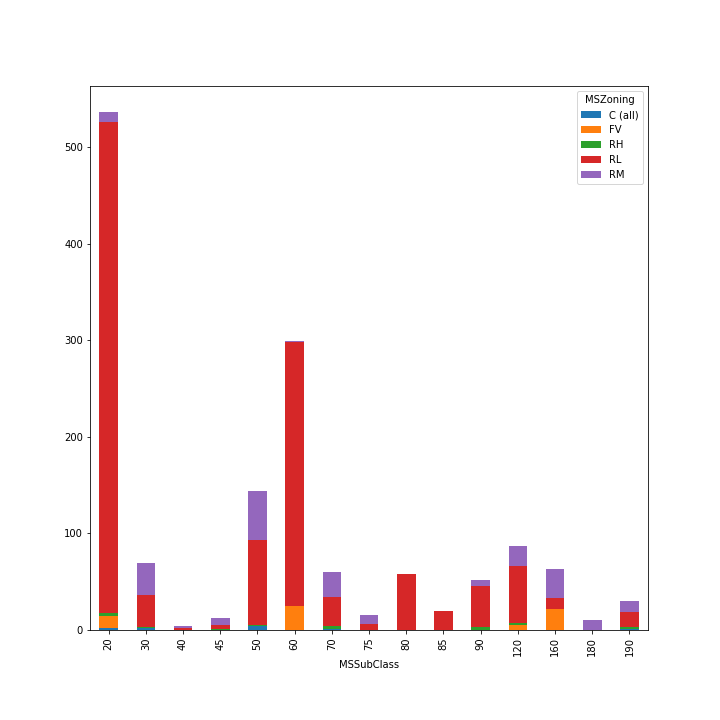

In [42]:
my_table = pd.crosstab(index = explore['MSSubClass'],
 columns = explore['MSZoning'])
print type(my_table)
my_table.plot.bar(stacked = True)

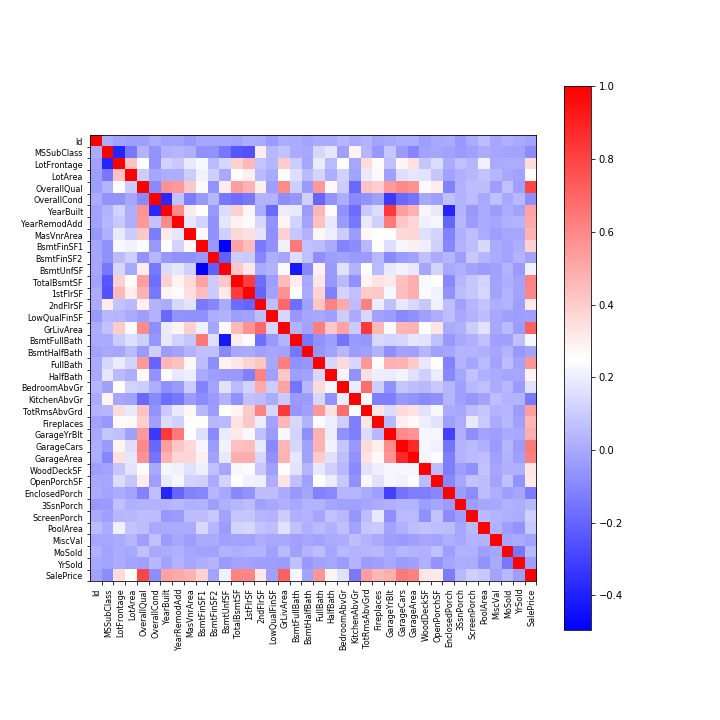

In [43]:
corrolation_heatmap(explore)


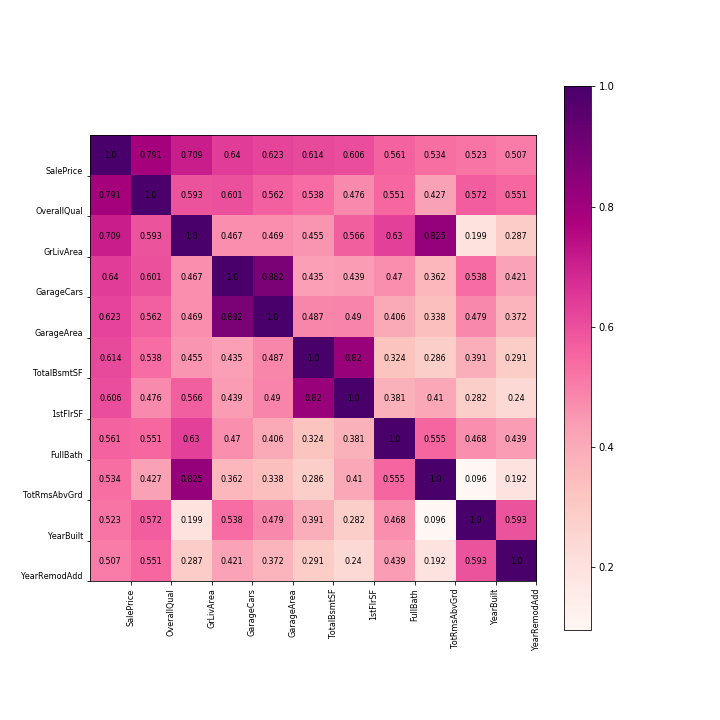

In [44]:
partial_corrolation_plot(explore, target = 'SalePrice', k = 10)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118418d50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a3d01d0>]], dtype=object)

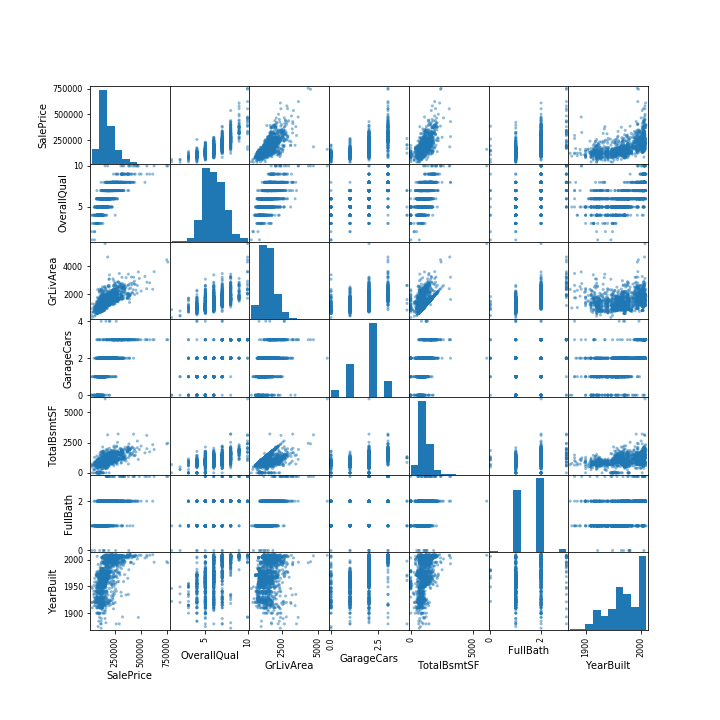

In [46]:
linear_attributes = ["SalePrice","OverallQual", "GrLivArea",
"GarageCars","TotalBsmtSF","FullBath","YearBuilt"]

scatter_matrix(explore[linear_attributes])